In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
sns.set()

In [2]:
def get_state(data, t, n):
    d = t - n + 1
    block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1]
    res = []
    for i in range(n - 1):
        res.append(block[i + 1] - block[i])
    return np.array([res])

In [3]:
df = pd.read_csv('TSLA.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-07-31,335.500000,341.489990,321.040009,323.470001,323.470001,8535100
1,2017-08-01,323.000000,324.450012,316.130005,319.570007,319.570007,8303100
2,2017-08-02,318.940002,327.119995,311.220001,325.890015,325.890015,13091500
3,2017-08-03,345.329987,350.000000,343.149994,347.089996,347.089996,13535000
4,2017-08-04,347.000000,357.269989,343.299988,356.910004,356.910004,9268900


In [4]:
close = df.Close.values.tolist()
window_size = 30
skip = 1
l = len(close) - 1

In [5]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(self, weights, reward_function, population_size, sigma, learning_rate):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(self.weights, population[k])
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / np.std(rewards)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = w + self.learning_rate/(self.population_size * self.sigma) * np.dot(A.T, rewards).T
            if (i+1) % print_every == 0:
                print('iter %d. reward: %f' %  (i+1, self.reward_function(self.weights)))
        print('time taken to train:', time.time()-lasttime, 'seconds')
        
class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [np.random.randn(input_size, layer_size), 
                        np.random.randn(layer_size, output_size),
                        np.random.randn(layer_size, 1),
                        np.random.randn(1, layer_size)]
    
    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        buy = np.dot(feed, self.weights[2])
        return decision, buy
    
    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [6]:
class Agent:

    POPULATION_SIZE = 15
    SIGMA = 0.1
    LEARNING_RATE = 0.03
    
    def __init__(self, model, money, max_buy, max_sell):
        self.model = model
        self.initial_money = money
        self.max_buy = max_buy
        self.max_sell = max_sell
        self.es = Deep_Evolution_Strategy(self.model.get_weights(), self.get_reward, self.POPULATION_SIZE, self.SIGMA, self.LEARNING_RATE)
    
    def act(self, sequence):
        decision, buy = self.model.predict(np.array(sequence))
        return np.argmax(decision[0]), int(buy[0])
    
    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = get_state(close, 0, window_size + 1)
        inventory = []
        quantity = 0
        for t in range(0,l,skip):
            action, buy = self.act(state)
            next_state = get_state(close, t + 1, window_size + 1)
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
            elif action == 2 and len(inventory) > 0:
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell
                
            state = next_state
        return ((initial_money - starting_money) / starting_money) * 100
    
    def fit(self, iterations, checkpoint):
        self.es.train(iterations,print_every=checkpoint)
        
    def buy(self):
        initial_money = self.initial_money
        state = get_state(close, 0, window_size + 1)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        for t in range(0,l,skip):
            action, buy = self.act(state)
            next_state = get_state(close, t + 1, window_size + 1)
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
                states_buy.append(t)
                print('day %d: buy %d units at price %f, total balance %f'%(t,buy_units, total_buy,initial_money))
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                if sell_units < 1:
                    continue
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell
                states_sell.append(t)
                try:
                    invest = ((total_sell - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print('day %d, sell %d units at price %f, investment %f %%, total balance %f,'%(t, sell_units, total_sell, invest, initial_money))
            state = next_state
        
        invest = ((initial_money - starting_money) / starting_money) * 100
        print('\ntotal gained %f, total investment %f %%'%(initial_money - starting_money,invest))
        plt.figure(figsize=(20,10))
        plt.plot(close, label='true close',c='g')
        plt.plot(close, 'X', label='predict buy',markevery=states_buy, c='b')
        plt.plot(close, 'o', label='predict sell',markevery=states_sell,c='r')
        plt.legend()
        plt.show()

In [7]:
model = Model(window_size, 500, 3)
agent = Agent(model,10000,5,5)
agent.fit(500, 10)

iter 10. reward: 23.121199
iter 20. reward: 25.147096
iter 30. reward: 33.326796
iter 40. reward: 38.139497
iter 50. reward: 43.262399
iter 60. reward: 50.141300
iter 70. reward: 52.286500
iter 80. reward: 56.389802
iter 90. reward: 64.247402
iter 100. reward: 63.522098
iter 110. reward: 65.378202
iter 120. reward: 70.515604
iter 130. reward: 72.306606
iter 140. reward: 69.528703
iter 150. reward: 67.272104
iter 160. reward: 72.349605
iter 170. reward: 70.548099
iter 180. reward: 73.056404
iter 190. reward: 73.906506
iter 200. reward: 75.726407
iter 210. reward: 75.613906
iter 220. reward: 77.954305
iter 230. reward: 79.218006
iter 240. reward: 81.041707
iter 250. reward: 82.952206
iter 260. reward: 80.815607
iter 270. reward: 82.571307
iter 280. reward: 81.471304
iter 290. reward: 76.459204
iter 300. reward: 79.518202
iter 310. reward: 80.464405
iter 320. reward: 77.293202
iter 330. reward: 81.054904
iter 340. reward: 81.455003
iter 350. reward: 79.609004
iter 360. reward: 81.331204
i

day 0: buy 5 units at price 1617.350005, total balance 8382.649995
day 1: buy 5 units at price 1597.850035, total balance 6784.799960
day 2: buy 5 units at price 1629.450075, total balance 5155.349885
day 5, sell 5 units at price 1775.850065, investment 9.799985 %, total balance 6931.199950,
day 6, sell 5 units at price 1826.100005, investment 14.284818 %, total balance 8757.299955,
day 7, sell 5 units at price 1817.649995, investment 11.549904 %, total balance 10574.949950,
day 15: buy 5 units at price 1689.299925, total balance 8885.650025
day 16: buy 5 units at price 1706.750030, total balance 7178.899995
day 17: buy 5 units at price 1763.849945, total balance 5415.050050
day 18: buy 5 units at price 1764.649965, total balance 3650.400085
day 19: buy 5 units at price 1740.249940, total balance 1910.150145
day 20: buy 5 units at price 1728.300020, total balance 181.850125
day 24, sell 5 units at price 1776.999970, investment 5.191502 %, total balance 1958.850095,
day 25: buy 5 units 

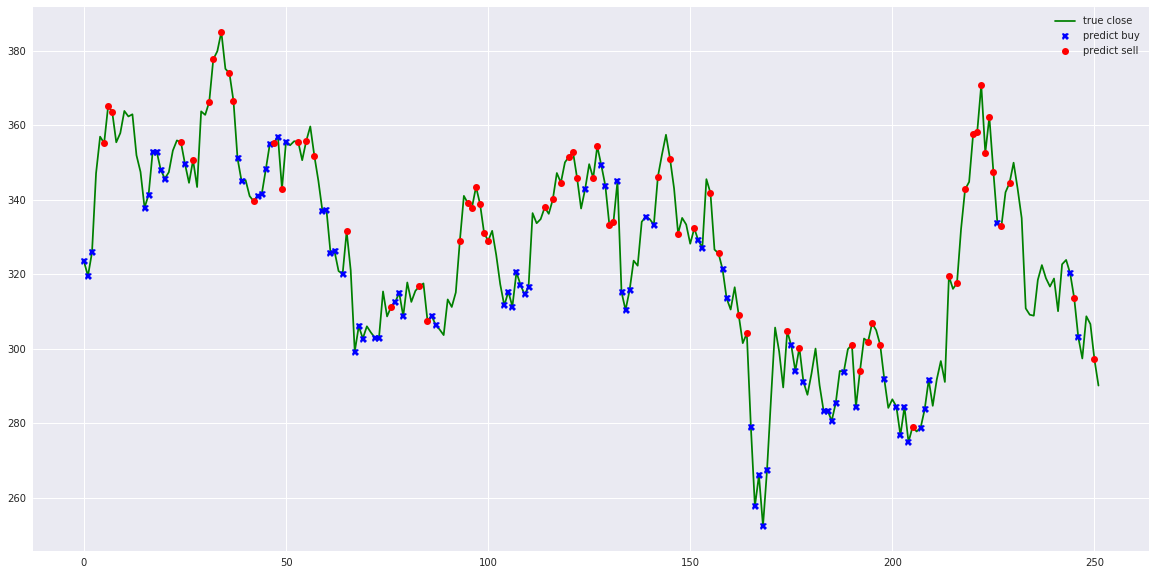

In [8]:
agent.buy()